# Building a Handbags-Shoes Classifier with Transfer Learning

(Note: Some code snippets adapted from [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb))

## Introduction

In this Colab, we first build a **convolutional neural network** to solve the handbags-shoes classification problem.

We then show how to use a technique called **data augmentation** to  increase the size of your training dataset, and thereby achieve better accuracy.

Next, we describe a very powerful technique called **Transfer Learning** that can be used to build highly accurate image classification models even when you have very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.



---


---

But, as usual, let's get some technical preliminaries out of the way first.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

Unlike the earlier colab where we used a dataset that comes packaged with Keras, in this colab we will work with our own data.

I have web-scraped approximately 100 color images each of handbags and shoes, packaged it up as a zip file and placed it in Dropbox.

The code below downloads this zip file and unzips it so that colab can access it.

In [2]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
!unzip -qq handbags-shoes.zip

## Data Pre-processing



Is "Deep Learning" even possible with so few examples? (for comparison: Fashion MNIST had **60,000** training examples).

YES!

We will now build a near-perfect handbags vs shoes classifier using **just** these 200 images!





---



---

We will split the data into train/validation/test sets so that we can monitor overfitting etc.     

In [3]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/handbags-shoes")


In [ ]:
#!rm -rf /content/handbags-shoes

In [4]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)
  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

handbags_vs_shoes/  
...train/   
......handbags/         
......shoes/    
...validation/    
......handbags/       
......shoes/         
...test/    
......handbags/     
......shoes/   




---



---




When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))


In [5]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 96 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 39 files belonging to 2 classes.


**Less than 100 examples in the training set!!**



Let's look at a few examples.

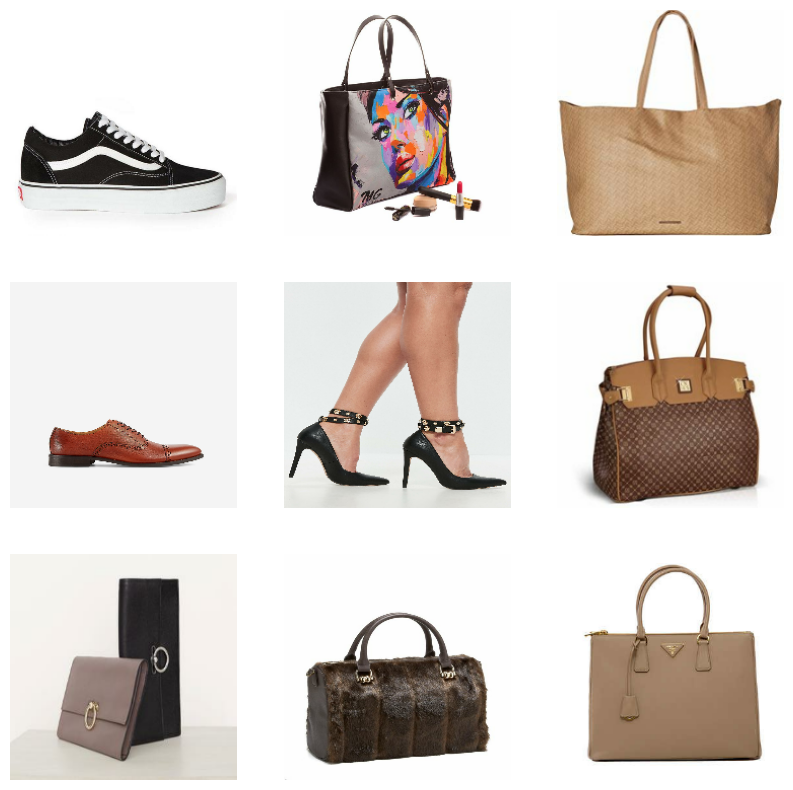

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## A Basic Convolutional Neural Network



---



---



We will try a simple CNN on this dataset with two convolutional + pooling layers

In [7]:
input = keras.Input(shape=(224,224,3))
h = keras.layers.Rescaling(1./255)(input)


# 1st convolutional block
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


# 2nd convolutional block
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


h = keras.layers.Flatten()(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                         

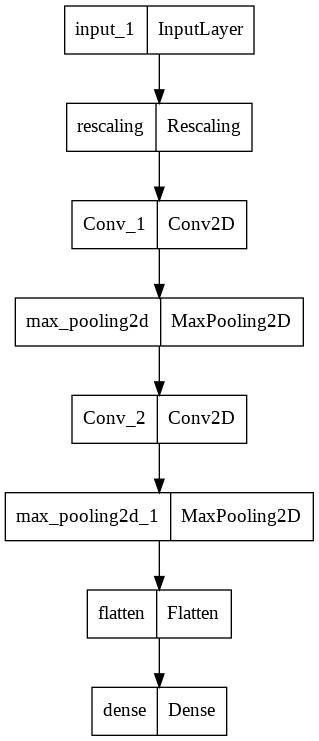

In [ ]:
keras.utils.plot_model(model)

In [8]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Note that we chose the `binary_cross_entropy` loss function above since this is just a **binary** classification problem (e.g., handbags or shoes).

This time around, we will tell Keras to track loss and accuracy on the **validation** set so we can keep an eye on any overfitting.

We will also store the results of running `model.fit` in the variable `history`. This will allow us to plot how the loss and accuracy changed from epoch to epoch etc. and thereby get a sense for any overfitting.

In [9]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 5s 272ms/step - loss: 1.9542 - accuracy: 0.4271 - val_loss: 0.8153 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 1s 252ms/step - loss: 1.2277 - accuracy: 0.5104 - val_loss: 1.0277 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 151ms/step - loss: 0.6764 - accuracy: 0.6146 - val_loss: 0.6849 - val_accuracy: 0.5400
Epoch 4/20
3/3 [==============================] - 1s 157ms/step - loss: 0.6511 - accuracy: 0.5417 - val_loss: 0.6914 - val_accuracy: 0.5400
Epoch 5/20
3/3 [==============================] - 1s 153ms/step - loss: 0.5468 - accuracy: 0.6667 - val_loss: 0.5579 - val_accuracy: 0.7600
Epoch 6/20
3/3 [==============================] - 1s 148ms/step - loss: 0.4109 - accuracy: 0.9062 - val_loss: 0.5444 - val_accuracy: 0.7800
Epoch 7/20
3/3 [==============================] - 1s 154ms/step - loss: 0.3650 - accuracy: 0.8958 - val_loss: 0.4832 - val_accuracy: 0.8000
Epoch 8/20
3/3 [====

In [11]:
# handy function to visualize how the changes with each epoch

def plot_learning_curve(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

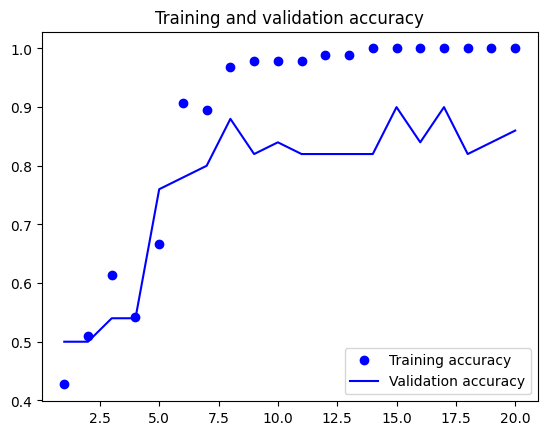

In [12]:
plot_learning_curve(history)

The model achieves a high training accuracy. This is not surprising, since our training dataset has only ~90 examples while our model has 101,345 parameters!

More importantly, notice how the validation accuracy plateaus in the 80s while the training accuracy is in the 90s. This  gap suggests **overfitting**.




Let's check the accuracy on the test set.

In [13]:
model.evaluate(test_dataset)

2/2 [==============================] - 1s 146ms/step - loss: 0.7050 - accuracy: 0.7692


[0.7049592137336731, 0.7692307829856873]

OK, what can we do to improve accuracy?

We can go back and scrape more data, of course, but that is a lot of work.

What else?

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



To demonstrate, here's a little Keras model that applies three transformations to an incoming image.

In [14]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

Let's apply it to an image from our training set to see what it produces.

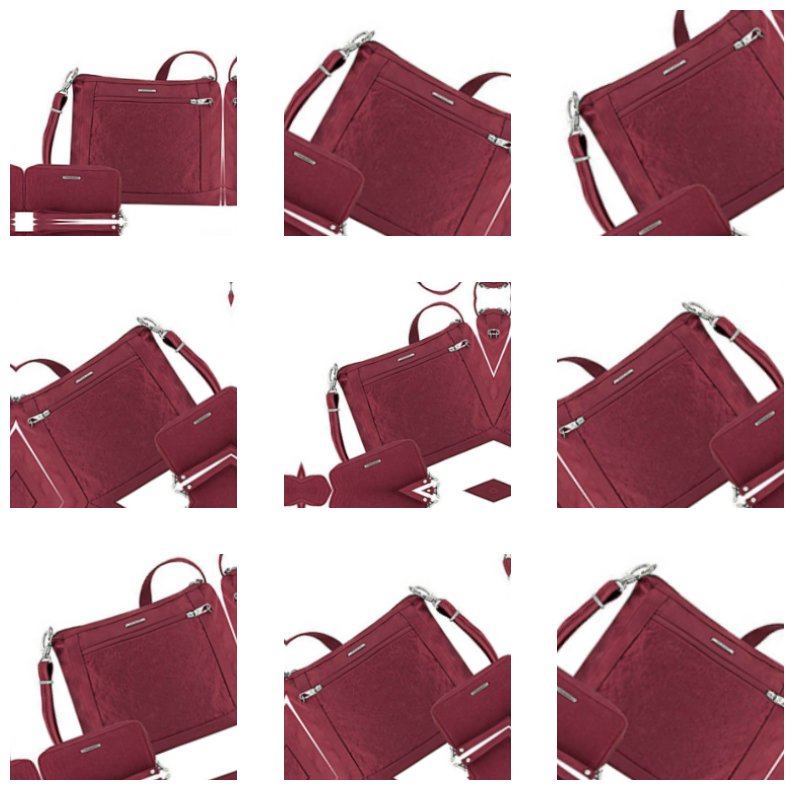

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We can add `data_augmentation` right after the input layer in the convolutional NN model we built earlier, and train the model as before. Because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

**Let's do it!**

In [16]:
input = keras.Input(shape=(224,224,3))

# we have inserted the data augmentation layer here
h = data_augmentation(input)
# rest of the model is the same as before

h = keras.layers.Rescaling(1./255)(h)

# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)
# pooling layer
h = keras.layers.MaxPool2D()(h)


h = keras.layers.Flatten()(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                           

In [18]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

I will train the model for 40 epochs, rather than 10.

In [19]:
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset)

Epoch 1/40
3/3 [==============================] - 2s 210ms/step - loss: 1.2740 - accuracy: 0.5417 - val_loss: 1.7066 - val_accuracy: 0.5000
Epoch 2/40
3/3 [==============================] - 1s 149ms/step - loss: 1.3566 - accuracy: 0.5312 - val_loss: 0.5190 - val_accuracy: 0.8200
Epoch 3/40
3/3 [==============================] - 1s 199ms/step - loss: 0.7050 - accuracy: 0.5625 - val_loss: 0.6313 - val_accuracy: 0.5000
Epoch 4/40
3/3 [==============================] - 1s 155ms/step - loss: 0.5756 - accuracy: 0.7083 - val_loss: 0.5382 - val_accuracy: 0.7000
Epoch 5/40
3/3 [==============================] - 1s 154ms/step - loss: 0.6021 - accuracy: 0.6771 - val_loss: 0.5370 - val_accuracy: 0.7000
Epoch 6/40
3/3 [==============================] - 1s 144ms/step - loss: 0.4974 - accuracy: 0.7708 - val_loss: 0.4593 - val_accuracy: 0.8000
Epoch 7/40
3/3 [==============================] - 1s 194ms/step - loss: 0.4752 - accuracy: 0.7812 - val_loss: 0.4718 - val_accuracy: 0.8400
Epoch 8/40
3/3 [====

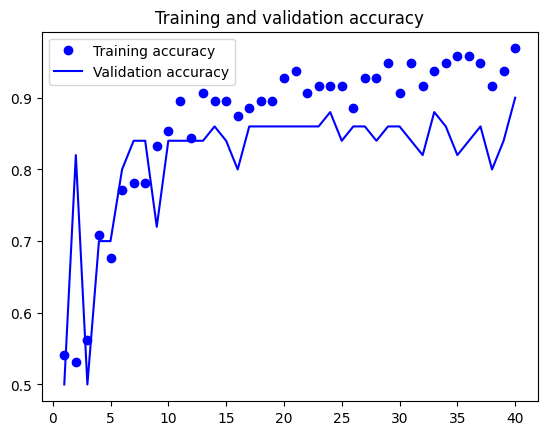

In [20]:
plot_learning_curve(history)

Compared to the no-augmentation model, we can see that (a) the gap between training and validation accuracies is smaller and (b) the validation accuracies are higher.

Let's check the accuracy on the test set.

In [21]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 10ms/step - loss: 0.7311 - accuracy: 0.7436


[0.7311258912086487, 0.7435897588729858]

Nice! Data augmentation helped!

## Model built with Transfer Learning




---

We will work with ResNet-50 since it comes pre-packaged with Keras.

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub)


In [22]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [23]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

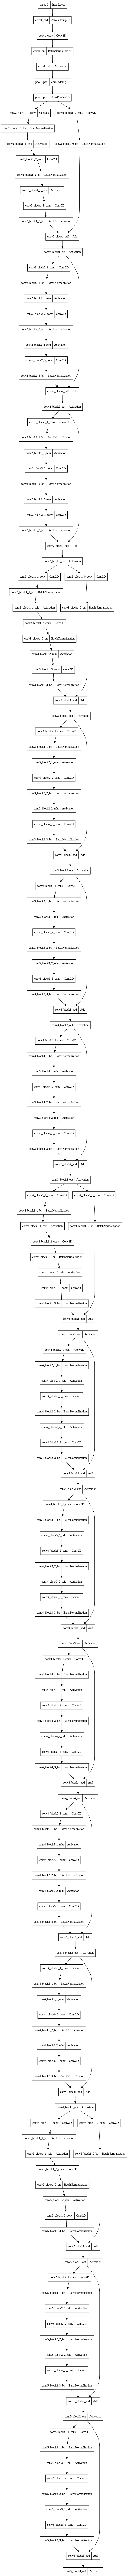

In [25]:
keras.utils.plot_model(resnet50_base)

It is a **DEEP** network, all right!!

Next, we run our dataset through this "headless ResNet" to get the transformed, "smart" inputs (as described in lecture).

In [24]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [26]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 945ms/step


In [27]:
train_features.shape

(96, 7, 7, 2048)

These 7 x 7 x 2048 cubes (rank-3 tensors) coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN, as described in lecture.

We will use a regularization layer that we haven't yet used: `Dropout`.

In [28]:
# This is the "smart" input from headless ResNet
input = keras.Input(shape=(7, 7, 2048))

# We flatten it into a vector
h = keras.layers.Flatten()(input)

# Run it through a dense layer with 256 relu neurons
h = keras.layers.Dense(256, activation="relu")(h)

# Apply dropout to 50% of the neurons
h = keras.layers.Dropout(0.5)(h)

# Run it through a single sigmoid neuron to get the prediction
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

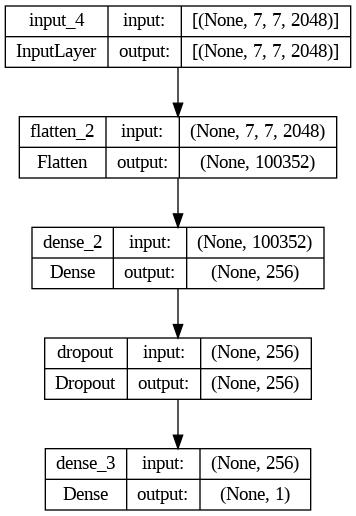

In [29]:
keras.utils.plot_model(model, show_shapes=True)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25690625 (98.00 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
  train_features, train_labels,
  epochs=10,
  validation_data=(val_features, val_labels))

Epoch 1/10
3/3 [==============================] - 2s 133ms/step - loss: 1.4054 - accuracy: 0.8125 - val_loss: 3.4395 - val_accuracy: 0.9200
Epoch 2/10
3/3 [==============================] - 0s 31ms/step - loss: 0.2631 - accuracy: 0.9792 - val_loss: 3.3013 - val_accuracy: 0.9600
Epoch 3/10
3/3 [==============================] - 0s 35ms/step - loss: 1.0200e-25 - accuracy: 1.0000 - val_loss: 2.6583 - val_accuracy: 0.9600
Epoch 4/10
3/3 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.1754 - val_accuracy: 0.9600
Epoch 5/10
3/3 [==============================] - 0s 35ms/step - loss: 4.8094e-14 - accuracy: 1.0000 - val_loss: 1.8163 - val_accuracy: 0.9600
Epoch 6/10
3/3 [==============================] - 0s 35ms/step - loss: 1.6014 - accuracy: 0.9896 - val_loss: 2.8220 - val_accuracy: 0.9600
Epoch 7/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.0932 - val_accuracy: 0.9600
Epoch 8/10

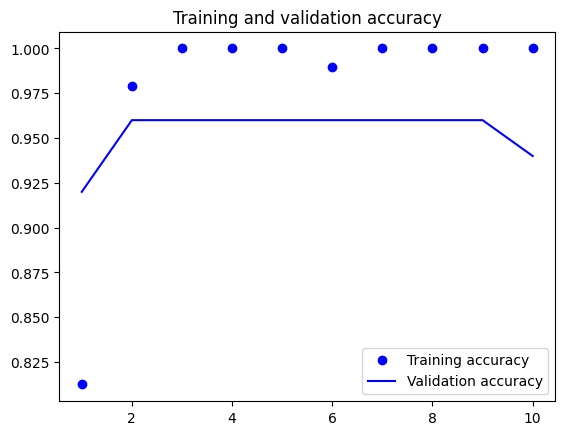

In [32]:
plot_learning_curve(history)

The training and validation accuracies are both very high! This looks promising!

In [33]:
model.evaluate(test_features, test_labels)

2/2 [==============================] - 0s 8ms/step - loss: 4.1407 - accuracy: 0.9231


[4.140749931335449, 0.9230769276618958]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!



---



---



If your computer has a webcam, you can test this model on **your** handbags and shoes: Run the code cells below and when a 'Capture' button appears, hold a shoe or handbag in front of it and click the button to get your prediction!

 Enjoy!!





In [35]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  return filename
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [45]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "S H O E" if pred > 0.5 else "HANDBAG"
  print("**********************")
  print(f"* That is a {pred}! *")
  print("**********************\n")

up next test01.jpg..


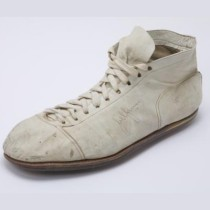

1/1 [==============================] - 0s 18ms/step
**********************
* That is a S H O E! *
**********************

up next test02.jpg..


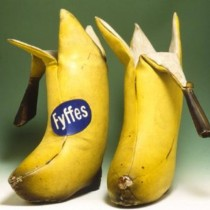

1/1 [==============================] - 0s 21ms/step
**********************
* That is a S H O E! *
**********************

up next test03.jpg..


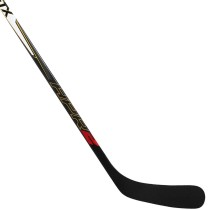

1/1 [==============================] - 0s 20ms/step
**********************
* That is a S H O E! *
**********************

up next test04.jpg..


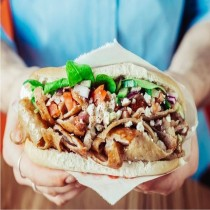

1/1 [==============================] - 0s 18ms/step
**********************
* That is a S H O E! *
**********************



In [46]:
from IPython.display import Image
def spinthedie(filename):
    print(f'up next {filename}..')
    display(Image(filename))
    predict_image(filename)

spinthedie('test01.jpg')  # Joel Garner's size 15's
spinthedie('test02.jpg')  # Billy Connely - Big Banana Boots
spinthedie('test03.jpg')  # A hocky stick
spinthedie('test04.jpg')  # British drunks fave - a donor kebab

**THE END**